In [3167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error ,mean_absolute_error ,r2_score,mean_absolute_percentage_error
import matplotlib.dates as mdates

import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [3168]:
com=5
commidity=['Bread (pita)', 'Rice (imported)', 'Oil (vegetable)', 'Pulses', 'Potatoes', 'Eggs', 'Meat (beef)', 'Meat (chicken)', 'Meat (chicken, whole)', 'Meat (lamb)', 'Cheese (white, boiled)', 'Milk (pasteurized)', 'Sugar', 'Oil (olive)', 'Beans (fava, dry)', 'Chickpeas', 'Lentils', 'Apples (red)', 'Bananas', 'Cucumbers', 'Garlic', 'Onions', 'Oranges (big size)', 'Tomatoes', 'Fuel (gas)', 'Fuel (kerosene)', 'Fuel (petrol-gasoline)', 'Bulgur', 'Pasta', 'Wheat flour', 'Fish (tuna, canned)', 'Cheese (picon)', 'Milk (powder)', 'Spinach', 'Salt (iodised)', 'Fuel (diesel)']
chosen_commidity=commidity[com]
chosen_commidity

'Eggs'

# ARIMA

In [3169]:
df=pd.read_csv('food_prices_jor.csv')
df.drop(['H-date','category','unit'],axis=1,inplace=True)
df['date']= pd.to_datetime(df['date'])
df=df.groupby(['date','commodity'])['price'].mean().reset_index()
oil_df = df[df['commodity'] == chosen_commidity].drop(['commodity'],axis=1)
oil_df.reset_index(drop=True, inplace=True)

In [3170]:
oil_df = oil_df.set_index('date')
oil_df

,price
date,
2012-07-15,3.5200
2012-08-15,3.5700
2012-09-15,3.4600
2012-10-15,3.4000
2012-11-15,3.4400
...,...
2022-08-15,2.5150
2022-09-15,2.6375
2022-10-15,2.7625


<AxesSubplot: xlabel='date'>

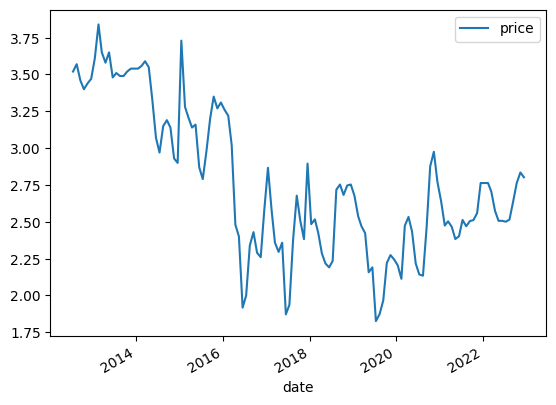

In [3171]:
oil_df.plot()

In [3172]:
len(oil_df)

126

In [3173]:
train_size = int(oil_df.shape[0]*0.8)
df_train = oil_df[:train_size].copy()
df_test = oil_df[train_size:].copy()

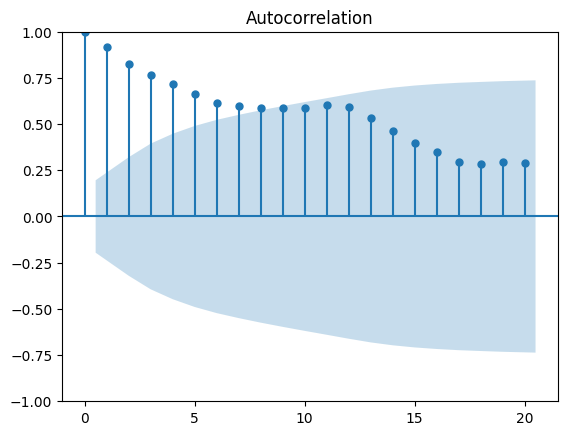

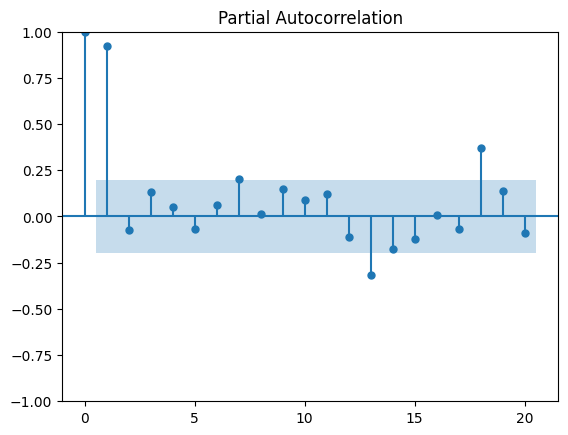

In [3174]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [3175]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2096486950478031


In [3176]:
train_size = int(oil_df.shape[0]*0.8)
df_train = oil_df[:train_size].copy()
df_test = oil_df[train_size:].copy()

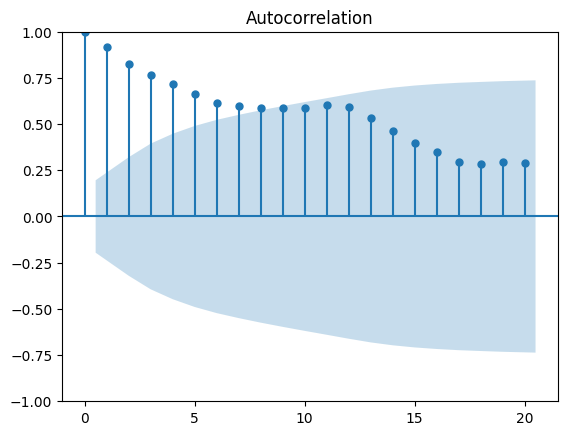

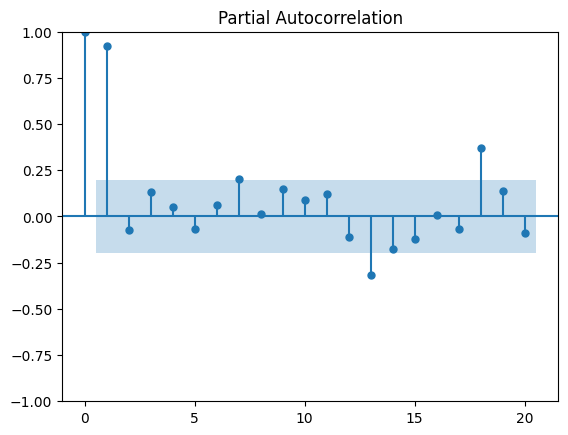

In [3177]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [3178]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2096486950478031


<AxesSubplot: xlabel='date'>

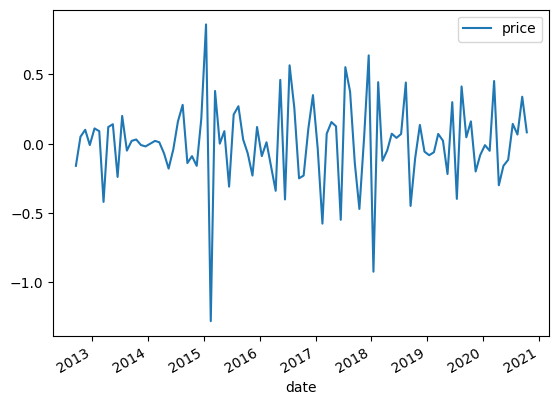

In [3179]:
df_train_diff = df_train.diff().dropna().diff().dropna()
df_train_diff.plot()

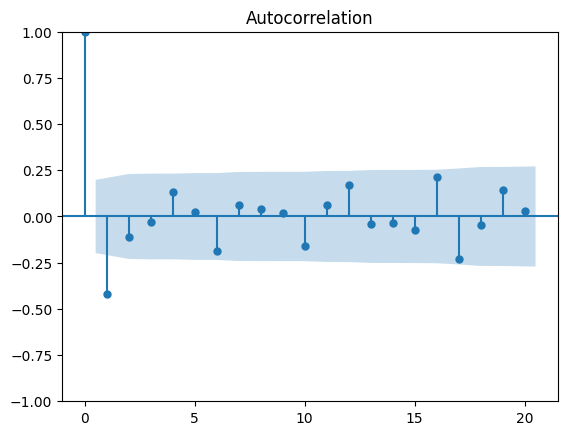

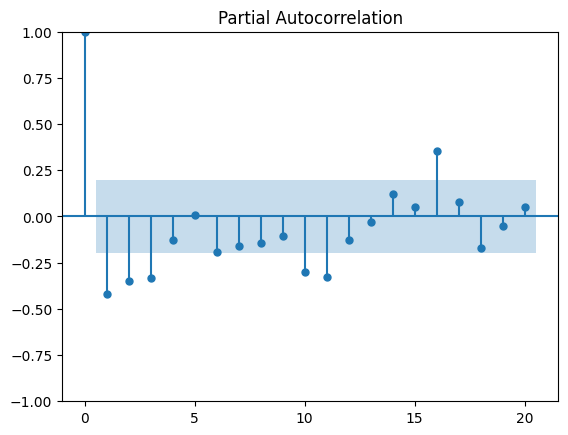

In [3180]:
acf_diff = plot_acf(df_train_diff)

pacf_diff = plot_pacf(df_train_diff)

In [3181]:
adf_test = adfuller(df_train_diff)
print(f'p-value: {adf_test[1]}')

p-value: 1.3589896623411037e-09


In [3182]:
from statsmodels.tsa.arima.model import ARIMA

In [3183]:
# params = [(p_value, d_value, q_value) for p_value in range(1, 10) for d_value in range(1, 6) for q_value in range(1, 10)]
# r = []
# o = []
# for orders in params:
#     model_test = ARIMA(df_train, order=orders).fit()
#     y_pred = model_test.forecast(len(df_test))
#     rmse= mean_squared_error(df_test, y_pred, squared=False)
#     r.append(rmse)
#     o.append(orders)
    
# df8 = pd.DataFrame(list(zip(o, r)),
#                columns =['Params', 'RMSE'])
# M = df8['Params'][df8['RMSE'].argmin()]
# print (df8 , f' \n ARIMA_Orders = {M}' )

In [3184]:
# M

In [3185]:
model = ARIMA(df_train, order=(8, 1, 5))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  100
Model:                 ARIMA(8, 1, 5)   Log Likelihood                  21.692
Date:                Mon, 20 Mar 2023   AIC                            -15.384
Time:                        15:56:37   BIC                             20.947
Sample:                             0   HQIC                            -0.685
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3305      1.042     -0.317      0.751      -2.372       1.711
ar.L2          0.0660      0.777      0.085      0.932      -1.456       1.588
ar.L3          0.2948      0.438      0.673      0.5

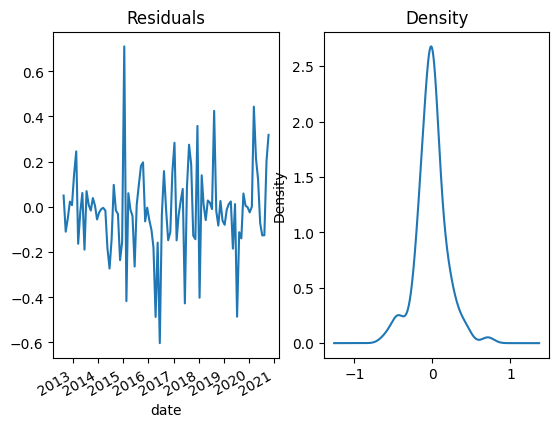

In [3186]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

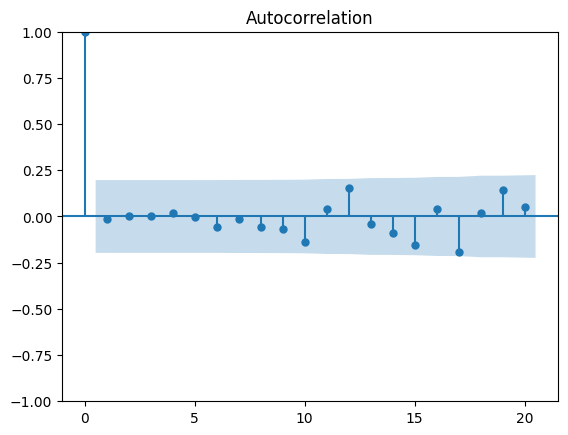

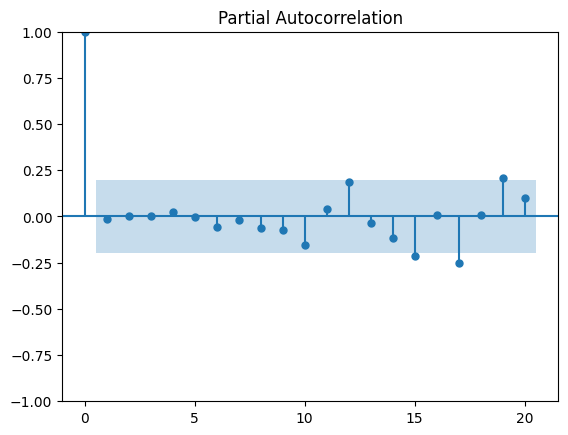

In [3187]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<AxesSubplot: xlabel='date'>

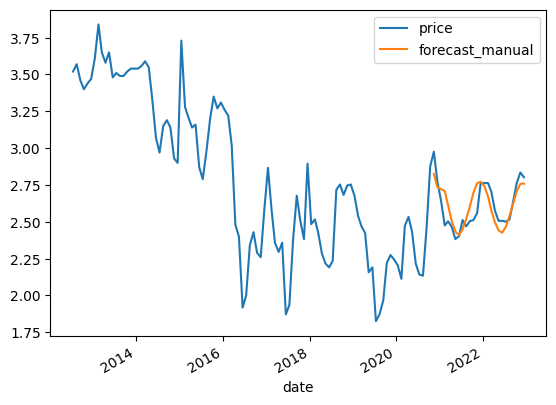

In [3188]:
forecast_test = model_fit.forecast(len(df_test))

oil_df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

oil_df.plot()

In [3189]:
import pmdarima as pm
auto_arima1 = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima1

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [3190]:
auto_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 1, 1)   Log Likelihood                  15.829
Date:                Mon, 20 Mar 2023   AIC                            -21.657
Time:                        15:56:41   BIC                             -8.682
Sample:                             0   HQIC                           -16.407
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0038      0.002     -1.805      0.071      -0.008       0.000
ar.L1          0.8724      0.095      9.151      0.000       0.686       1.059
ar.L2         -0.1500      0.106     -1.420      0.155      -0.357       0.057
ma.L1         -0.9578      0.055    -17.478      0.000      -1.065      -0.850
sigma2         0.0421      0.004     10.333      0.000       0.034       0.050
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                26.16
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.21
Prob(H) (two-sided):                  0.83   Kurtosis:                         5.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: xlabel='date'>

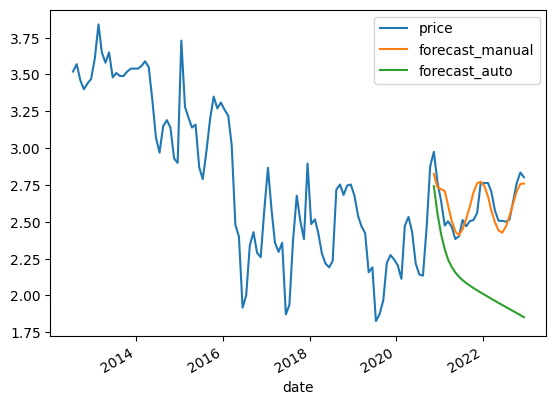

In [3191]:
forecast_test_auto = auto_arima1.predict(n_periods=len(df_test))
oil_df['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

oil_df.plot()

In [3192]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.07806665439035104
mape - manual: 0.030066802419972824
rmse - manual: 0.09772906267097164


In [3193]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 0.5212709758145629
mape - auto: 0.19788203145600342
rmse - auto: 0.5743054096918428


# 
---

# SARIMAX

## data reading and prep

In [3194]:
df=pd.read_csv('food_prices_jor.csv')

df.drop_duplicates(inplace=True) # droping the duplicates if there is any


df['date'] = pd.to_datetime(df['date']).dt.to_period('M') # to make new columns year , month

df=df.groupby(['H-date','date','category','commodity'])['price'].mean().reset_index()
df.sort_values(by=['date','category','commodity'],inplace=True)

df = df.loc[df['date'] > '2011-12-15' ] # filltering the data

def is_ramadan(x):
    if int(x.split(sep='/')[1]) in [8,9,10]:
        return 1
    else : 
        return 0
df['is_ramdan']=df['H-date'].apply(is_ramadan) # to make new columns with true false values (true when hijri months is equal to 8,9,10)

newdata=df # make a copy that will be used in the function

df=df.loc[df['commodity']==chosen_commidity] # to filter the df inrto one commodity df  

df.set_index(df['date'],inplace=True)
df.index=df.index.to_timestamp()

df.drop(['H-date','category','commodity','date'],axis=1,inplace=True) # droping the un needed columns 

df

,price,is_ramdan
date,,
2012-07-01,3.5200,1
2012-08-01,3.5700,1
2012-09-01,3.4600,1
2012-10-01,3.4000,0
2012-11-01,3.4400,0
...,...,...
2022-08-01,2.5150,0
2022-09-01,2.6375,0
2022-10-01,2.7625,0


## seasonal trend

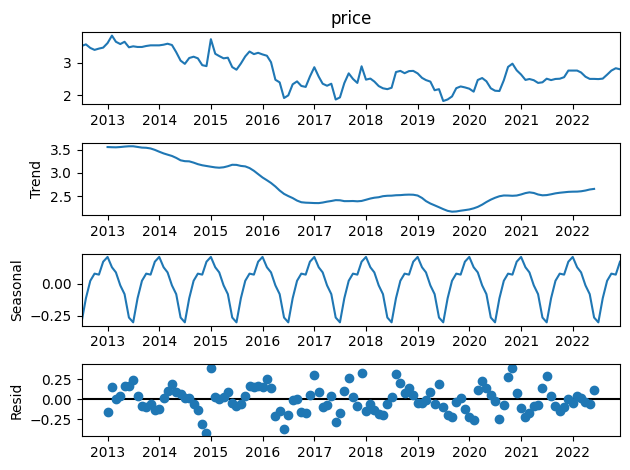

In [3195]:
res=seasonal_decompose(df['price'])
res.plot();

In [3196]:
# spliting 
train_df = df.iloc[:-40]
test_df = df.iloc[-40:]

In [3197]:
auto_arima(train_df['price'],m=1,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.650, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.093, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.142, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.311, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12.792, Time=0.22 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15.891, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-12.408, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-12.234, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.210, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(1, 1, 3)   Log Likelihood                  13.945
Date:                Mon, 20 Mar 2023   AIC                            -15.891
Time:                        15:56:44   BIC                             -1.235
Sample:                    07-01-2012   HQIC                            -9.996
                         - 08-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0060      0.005     -1.302      0.193      -0.015       0.003
ar.L1          0.6775      0.255      2.653      0.008       0.177       1.178
ma.L1         -0.8321      0.298     -2.789      0.005      -1.417      -0.247
ma.L2         -0.1662      0.169     -0.982      0.326      -0.498       0.165
ma.L3          0.0146      0.230      0.063      0.950      -0.436       0.466
sigma2         0.0414      0.006      7.259      0.000       0.030       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.38
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.16   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3198]:
# SARIMAX(1, 1, 1)x(0, 0, [1, 2], 12)


<AxesSubplot: xlabel='date'>

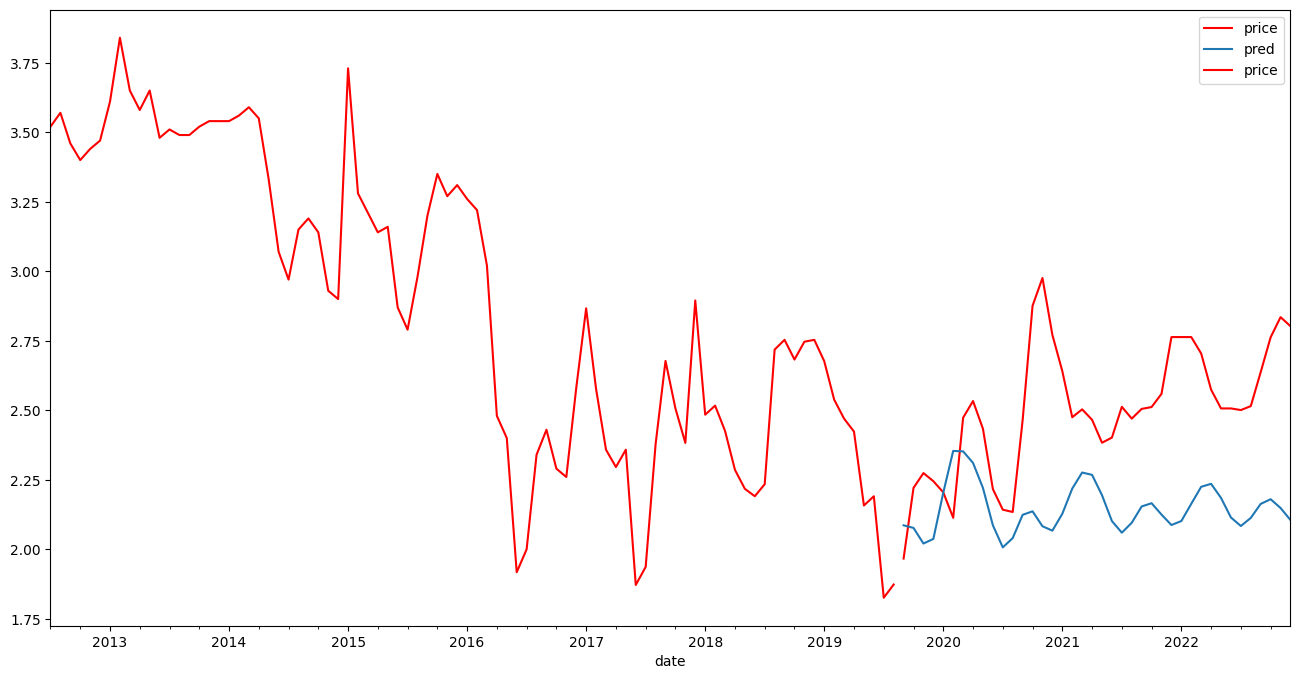

In [3199]:
# spliting 
train_df = df.iloc[:-40]
test_df = df.iloc[-40:]

# build the model
mod = SARIMAX (train_df['price'], order=(9,1,2), seasonal_order=(0, 0, 0, 0))
res =mod.fit()

# the start and end of the prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

# predicting the price 
prediction =res.predict(start,end).rename('pred')

# plot the prediction with the actual price 
ax=test_df['price'].plot(legend=True,figsize=(16,8),color='r')
prediction.plot(legend=True)
train_df['price'].plot(legend=True,color='r')




In [3200]:
# to test the results 

mse = mean_squared_error(test_df['price'], prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['price'], prediction)
r2 = r2_score(test_df['price'], prediction)

# print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 0.18
Root Mean Squared Error (RMSE): 0.43
Mean Absolute Error (MAE): 0.37
R-squared (R²): -2.49


In [3201]:
auto_arima(train_df['price'],exogenous=df[['is_ramdan']],seasonal= True,m=1,trace=True).summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-15.650, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.982, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-12.093, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-12.142, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-15.311, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-12.792, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-15.891, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-12.408, Time=0.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-12.234, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-12.210, Time=0.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   86
Model:               SARIMAX(1, 1, 3)   Log Likelihood                  13.945
Date:                Mon, 20 Mar 2023   AIC                            -15.891
Time:                        15:56:47   BIC                             -1.235
Sample:                    07-01-2012   HQIC                            -9.996
                         - 08-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0060      0.005     -1.302      0.193      -0.015       0.003
ar.L1          0.6775      0.255      2.653      0.008       0.177       1.178
ma.L1         -0.8321      0.298     -2.789      0.005      -1.417      -0.247
ma.L2         -0.1662      0.169     -0.982      0.326      -0.498       0.165
ma.L3          0.0146      0.230      0.063      0.950      -0.436       0.466
sigma2         0.0414      0.006      7.259      0.000       0.030       0.053
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                27.38
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               4.16   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [3202]:
# start = len(train_df)
# end = len(train_df) + len(test_df) - 1
# acc=5
# parms=()
# for i in range(10):
#     for j in range(10):
#         for k in range(10):
#             mod = SARIMAX (train_df['price'],exog=train_df[['is_ramdan']], order=(i,j,k), seasonal_order=(0, 0, 0, 0))
#             res =mod.fit()
            
#             prediction =res.predict(start,end,exog=test_df[['is_ramdan']]).rename('pred with ram')

#             mse = mean_squared_error(test_df['price'], prediction)
#             rmse = np.sqrt(mse)
#             if rmse<acc:
#                 parms=(i,j,k)
#                 acc=rmse

#             # plot the prediction with the actual price 
#             # ax=test_df['price'].plot(legend=True,figsize=(16,8),color='r')
#             # prediction.plot(legend=True)
#             # train_df['price'].plot(legend=True,color='r')
#             # for x in df[df['is_ramdan']==1].index:
#             #     ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)
#             # plt.title(f"{i=},{j=},{k=}")
#             # # plt.show()

In [3203]:
# print(acc)
# print(parms)

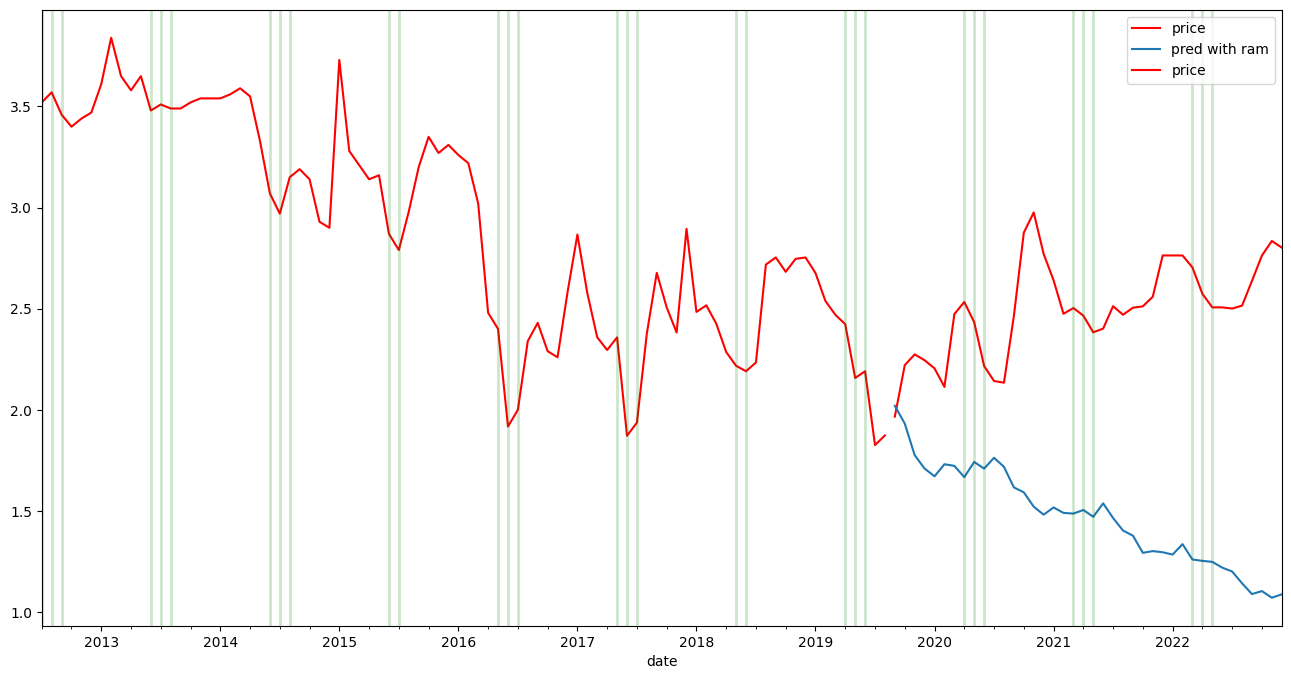

In [3204]:
# SARIMAX(2, 1, 2)(0,0,0)[0] 

# build the model
mod = SARIMAX (train_df['price'],exog=train_df[['is_ramdan']], order=(8, 2, 6), seasonal_order=(0, 0, 0, 0))
res =mod.fit()

# the start and end of the prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

# predicting the price 
prediction =res.predict(start,end,exog=test_df[['is_ramdan']]).rename('pred with ram')

# plot the prediction with the actual price 
ax=test_df['price'].plot(legend=True,figsize=(16,8),color='r')
prediction.plot(legend=True)
train_df['price'].plot(legend=True,color='r')
for x in df[df['is_ramdan']==1].index:
    ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)

In [3205]:
# to test the results 
mse = mean_squared_error(test_df['price'], prediction)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_df['price'], prediction)
r2 = r2_score(test_df['price'], prediction)

# print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 1.25
Root Mean Squared Error (RMSE): 1.12
Mean Absolute Error (MAE): 1.04
R-squared (R²): -22.85


##
---

In [3206]:
df_all_23=pd.read_excel('test.xlsx')
df_all_23['date']=df_all_23[['year','month']].apply(lambda x: '-'.join(x.values.astype(str)), axis=1)
df_all_23['date']=pd.to_datetime(df_all_23['date']).dt.to_period('M')



## testing SARIMAX

In [3207]:
# # filtring to a specific commodity
# data=df_all_23[df_all_23['commodity']==com]

# # prep the dataframe

# data.set_index(data['date'],inplace=True)
# data.index=data.index.to_timestamp()

# data.drop(['category','commodity','month','year','date','population','middle_east','world'],axis=1,inplace=True)

# # predicting the price 
# prediction =res.predict(data.index ,exog=data[['is_ramdan']]).rename('pred with ram')

# # plot the prediction with the actual price 
# ax=prediction.plot(legend=True,figsize=(16,8),linestyle='--')
# df['price'].plot()

# for x in data[data['is_ramdan']==1].index:
#     ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)

# for x in df[df['is_ramdan']==1].index:
#     ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)

# plt.title(f'{commidity[com]} price')
# plt.grid()


In [3208]:
def model_builder(thecom):

    newdata=newdata.loc[newdata['commodity']==commidity[thecom]] # to filter the newdata inrto one commodity newdata  
    newdata.set_index(newdata['date'],inplace=True)
    newdata.index=newdata.index.to_timestamp()
    newdata.drop(['H-date','category','commodity','date'],axis=1,inplace=True) # droping the un needed columns


    get_parametes = auto_arima(newdata['price'],exogenous=newdata[['is_ramdan']],seasonal= True,m=1,trace=True).get_params()
    order_aa = get_parametes.get('order')
    seasonal_order_aa = get_parametes.get('seasonal_order')

    # build the model
    mod = SARIMAX (newdata['price'], order=order_aa, seasonal_order=seasonal_order_aa)
    res =mod.fit()
    
    # filtring to a specific commodity
    data=df_all_23[df_all_23['commodity']==thecom]

    # prep the dataframe
    data.set_index(data['date'],inplace=True)
    data.drop(['category','commodity','month','year','date','population','middle_east','world'],axis=1,inplace=True)

    # predicting the price 
    prediction =res.predict(start='2023-01-01',end='2023-12-01' ,exog=data[['is_ramdan']]).rename('pred with ram')

    # plot the prediction with the actual price 
    ax=prediction.plot(legend=True,figsize=(16,8),linestyle='--')
    df['price'].plot()

    for x in data[data['is_ramdan']==1].index:
        ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)

    for x in df[df['is_ramdan']==1].index:
        ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)

    plt.title(f'{commidity[thecom]} price')
    plt.grid()
    plt.show()
    

# prophet

In [3209]:
# %pip install pystan~=2.14
# %pip install fbprophet

In [3210]:
import prophet

In [3211]:
com=5
commidity=['Bread (pita)', 'Rice (imported)', 'Oil (vegetable)', 'Pulses', 'Potatoes', 'Eggs', 'Meat (beef)', 'Meat (chicken)', 'Meat (chicken, whole)', 'Meat (lamb)', 'Cheese (white, boiled)', 'Milk (pasteurized)', 'Sugar', 'Oil (olive)', 'Beans (fava, dry)', 'Chickpeas', 'Lentils', 'Apples (red)', 'Bananas', 'Cucumbers', 'Garlic', 'Onions', 'Oranges (big size)', 'Tomatoes', 'Fuel (gas)', 'Fuel (kerosene)', 'Fuel (petrol-gasoline)', 'Bulgur', 'Pasta', 'Wheat flour', 'Fish (tuna, canned)', 'Cheese (picon)', 'Milk (powder)', 'Spinach', 'Salt (iodised)', 'Fuel (diesel)']
chosen_commidity=commidity[com]
chosen_commidity

'Eggs'

In [3212]:
df=pd.read_csv('food_prices_jor.csv')

df.drop_duplicates(inplace=True) # droping the duplicates if there is any


df['date'] = pd.to_datetime(df['date']).dt.to_period('M') # to make new columns year , month

df=df.groupby(['H-date','date','category','commodity'])['price'].mean().reset_index()
df.sort_values(by=['date','category','commodity'],inplace=True)

df = df.loc[df['date'] > '2011-12-15' ] # filltering the data

def is_ramadan(x):
    if int(x.split(sep='/')[1]) in [8,9,10]:
        return 1
    else : 
        return 0
df['is_ramdan']=df['H-date'].apply(is_ramadan) # to make new columns with true false values (true when hijri months is equal to 8,9,10)

newdata=df

df=df.loc[df['commodity']==chosen_commidity] # to filter the df inrto one commodity df  

df.set_index(df['date'],inplace=True)
df.index=df.index.to_timestamp()

df.drop(['H-date','category','commodity','date'],axis=1,inplace=True) # droping the un needed columns 

In [3213]:
data_2=newdata
newdata=newdata[newdata['commodity']==chosen_commidity].drop(['H-date','category','commodity','is_ramdan'],axis=1).reset_index(drop=True).rename(columns={'date':'ds','price':'y'})
newdata['ds']=newdata['ds'].dt.to_timestamp()


In [3214]:
newdata

,ds,y
0,2012-07-01,3.5200
1,2012-08-01,3.5700
2,2012-09-01,3.4600
3,2012-10-01,3.4000
4,2012-11-01,3.4400
...,...,...
121,2022-08-01,2.5150
122,2022-09-01,2.6375
123,2022-10-01,2.7625
124,2022-11-01,2.8350


In [3215]:
train_newdata=newdata.iloc[:-20]
test_newdata=newdata.iloc[-20:]

In [3216]:
model = prophet.Prophet()
model.fit(newdata)

prophet_pred=model.predict(newdata)

15:56:49 - cmdstanpy - INFO - Chain [1] start processing
15:56:49 - cmdstanpy - INFO - Chain [1] done processing


In [3217]:
future=model.make_future_dataframe(periods=40,freq='M',include_history=False)
forecast=model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-12-31,2.645185,2.608431,3.133052,2.645185,2.645261,0.225717,0.225717,0.225717,0.225717,0.225717,0.225717,0.0,0.0,0.0,2.870901
1,2023-01-31,2.652461,2.455992,2.987238,2.652126,2.653217,0.046674,0.046674,0.046674,0.046674,0.046674,0.046674,0.0,0.0,0.0,2.699135
2,2023-02-28,2.659033,2.463794,3.000343,2.657844,2.660637,0.075414,0.075414,0.075414,0.075414,0.075414,0.075414,0.0,0.0,0.0,2.734447
3,2023-03-31,2.666309,2.494642,3.038743,2.663742,2.669131,0.096216,0.096216,0.096216,0.096216,0.096216,0.096216,0.0,0.0,0.0,2.762525
4,2023-04-30,2.673351,2.293443,2.818394,2.669296,2.677555,-0.110880,-0.110880,-0.110880,-0.110880,-0.110880,-0.110880,0.0,0.0,0.0,2.562471
5,2023-05-31,2.680627,2.376120,2.915140,2.674957,2.686626,-0.045723,-0.045723,-0.045723,-0.045723,-0.045723,-0.045723,0.0,0.0,0.0,2.634904
6,2023-06-30,2.687668,1.980145,2.524112,2.679795,2.695126,-0.434463,-0.434463,-0.434463,-0.434463,-0.434463,-0.434463,0.0,0.0,0.0,2.253205
7,2023-07-31,2.694945,2.207630,2.780605,2.684746,2.704653,-0.199489,-0.199489,-0.199489,-0.199489,-0.199489,-0.199489,0.0,0.0,0.0,2.495456
8,2023-08-31,2.702221,2.385156,2.924223,2.689893,2.714271,-0.050030,-0.050030,-0.050030,-0.050030,-0.050030,-0.050030,0.0,0.0,0.0,2.652191
9,2023-09-30,2.709262,2.619083,3.160435,2.694875,2.723706,0.182017,0.182017,0.182017,0.182017,0.182017,0.182017,0.0,0.0,0.0,2.891279


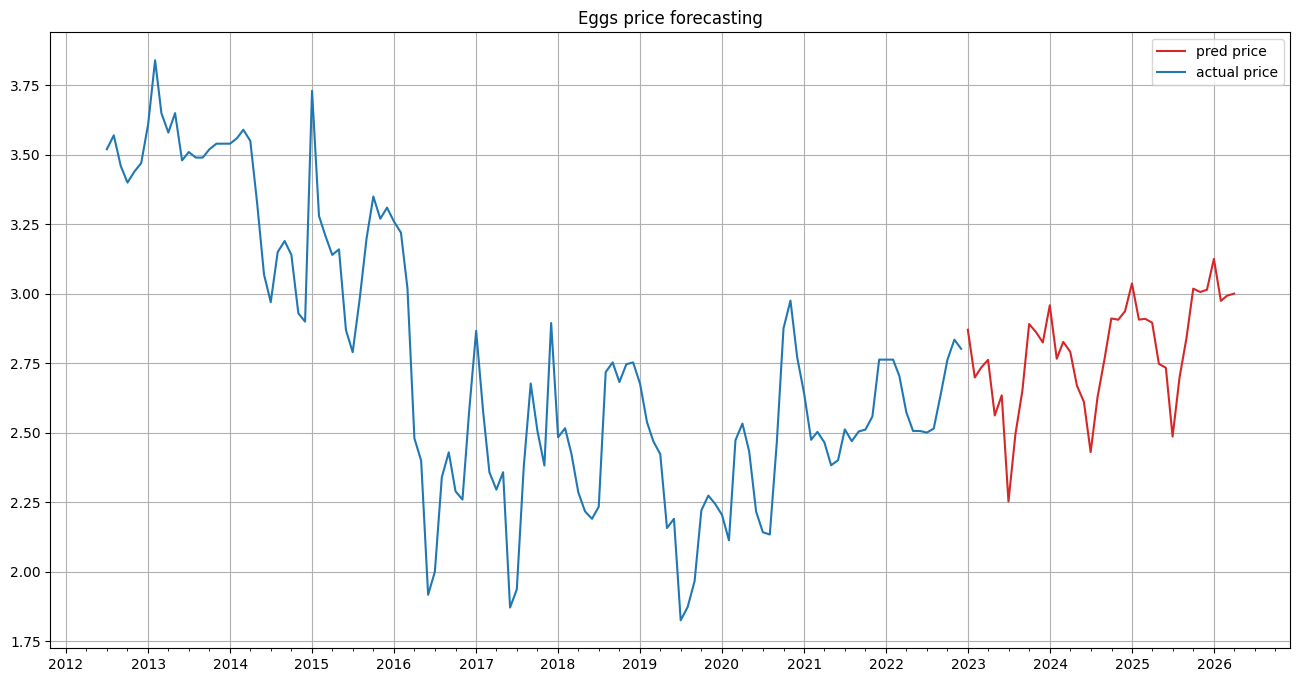

In [3218]:
# plot the prediction with the actual price 

fig,ax=plt.subplots(figsize=(16,8))
ax.plot(forecast['ds'], forecast['yhat'], color='tab:red',label='pred price')
ax.plot(newdata['ds'], newdata['y'], color='tab:blue',label='actual price')


# ax.set_xticks()
# ax.set_xticklabels(alldata['ds'])
ax.legend(loc='upper right')

date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.title(f'{chosen_commidity} price forecasting')
plt.grid()
plt.savefig(f'{chosen_commidity} price prediction')
plt.show()

In [3219]:
prophet_pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-07-01,3.747859,3.245694,3.784293,3.747859,3.747859,-0.230159,-0.230159,-0.230159,-0.230159,-0.230159,-0.230159,0.0,0.0,0.0,3.517701
1,2012-08-01,3.725306,3.368799,3.891473,3.725306,3.725306,-0.082660,-0.082660,-0.082660,-0.082660,-0.082660,-0.082660,0.0,0.0,0.0,3.642646
2,2012-09-01,3.702753,3.443637,3.993021,3.702753,3.702753,0.025127,0.025127,0.025127,0.025127,0.025127,0.025127,0.0,0.0,0.0,3.727880
3,2012-10-01,3.680928,3.460765,3.962348,3.680928,3.680928,0.033746,0.033746,0.033746,0.033746,0.033746,0.033746,0.0,0.0,0.0,3.714674
4,2012-11-01,3.658375,3.438778,3.959882,3.658375,3.658375,0.044923,0.044923,0.044923,0.044923,0.044923,0.044923,0.0,0.0,0.0,3.703298


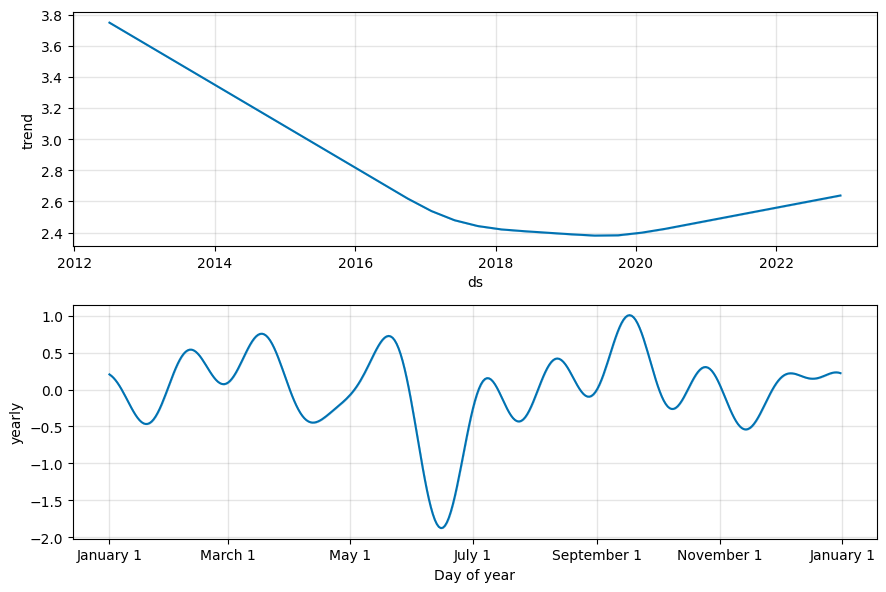

In [3220]:
model.plot_components(prophet_pred);

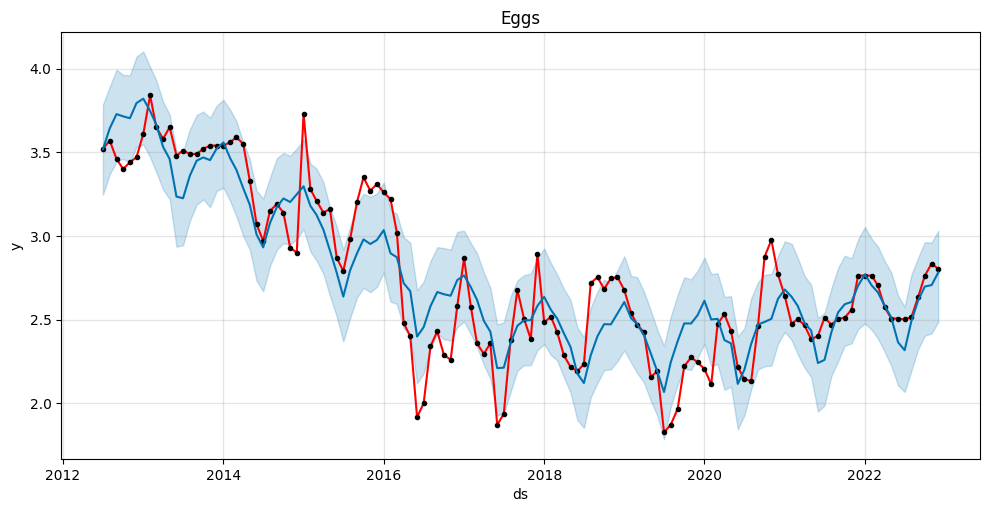

In [3221]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(newdata['ds'],newdata['y'],color='r')
fig=model.plot(prophet_pred,ax=ax)
plt.title(f'{chosen_commidity}')
# 
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


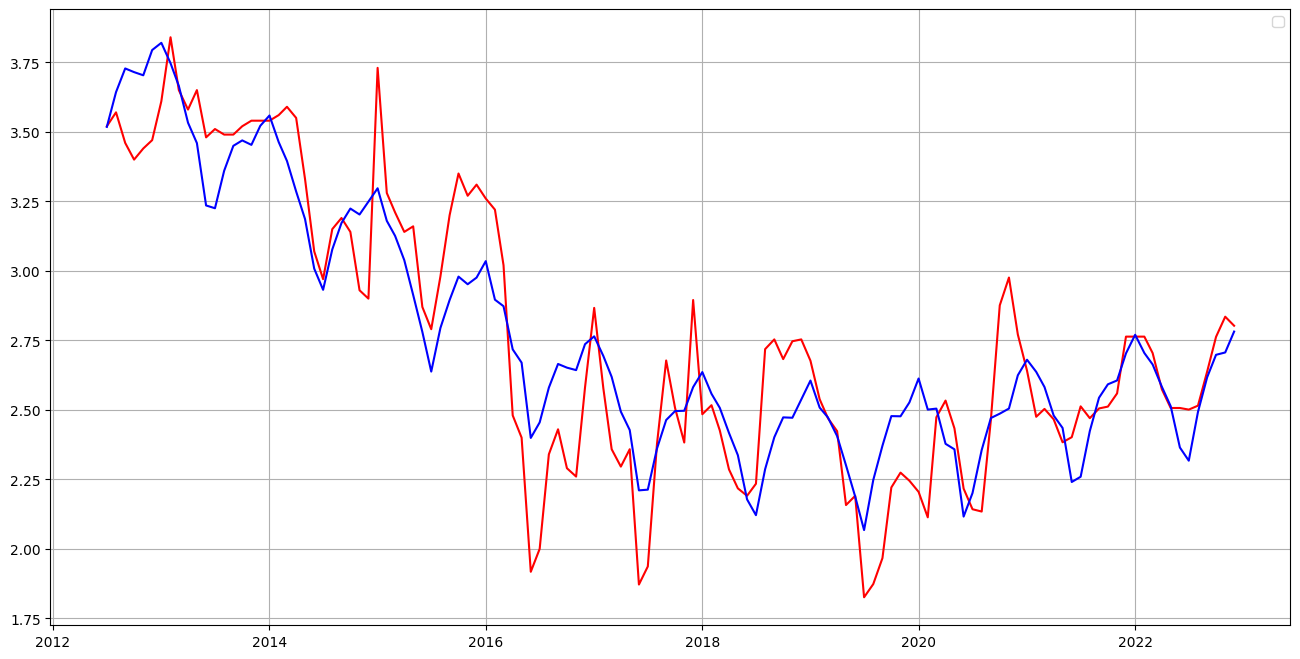

In [3222]:
# plot the prediction with the actual price 
fig,ax=plt.subplots(figsize=(16,8))
ax.plot(newdata['ds'],newdata['y'],color='r',)
plt.plot(prophet_pred['ds'],prophet_pred['yhat'],color='b')
plt.legend()
plt.grid()
plt.show()

In [3223]:
# to test the results 
mse = mean_squared_error(newdata['y'], prophet_pred['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(newdata['y'], prophet_pred['yhat'])
r2 = r2_score(newdata['y'], prophet_pred['yhat'])
mape=mean_absolute_percentage_error(newdata['y'], prophet_pred['yhat'])
# print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean absolute percentage error: {mape:.2f}")
print(f"R-squared (R²): {r2:.2f}")




Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.17
Mean absolute percentage error: 0.06
R-squared (R²): 0.82


## adding ramdan

In [3224]:
data_2=data_2[data_2['commodity']==chosen_commidity].drop(['H-date','category','commodity','price'],axis=1).reset_index(drop=True).rename(columns={'date':'ds','is_ramdan':'holiday'})
data_2['ds']=data_2['ds'].dt.to_timestamp()

In [3225]:
data_2['holiday']=data_2['holiday'].replace({1:'ramdan',
                                             0:'not ramdan'})


In [3226]:
data_2

,ds,holiday
0,2012-07-01,ramdan
1,2012-08-01,ramdan
2,2012-09-01,ramdan
3,2012-10-01,not ramdan
4,2012-11-01,not ramdan
...,...,...
121,2022-08-01,not ramdan
122,2022-09-01,not ramdan
123,2022-10-01,not ramdan
124,2022-11-01,not ramdan


In [3227]:
train_data_2=data_2.iloc[:-20]
test_data_2=data_2.iloc[-20:]

In [3228]:
model = prophet.Prophet(holidays=data_2)
model.fit(newdata)

prophet_pred=model.predict(newdata)

15:56:51 - cmdstanpy - INFO - Chain [1] start processing
15:56:51 - cmdstanpy - INFO - Chain [1] done processing


In [3229]:
prophet_pred.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,ramdan,ramdan_lower,ramdan_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-07-01,3.667546,3.215529,3.784343,3.667546,3.667546,-0.166508,-0.166508,-0.166508,0.033307,...,0.033307,0.033307,0.033307,-0.199815,-0.199815,-0.199815,0.0,0.0,0.0,3.501037
1,2012-08-01,3.644317,3.326631,3.880034,3.644317,3.644317,-0.044215,-0.044215,-0.044215,0.033307,...,0.033307,0.033307,0.033307,-0.077521,-0.077521,-0.077521,0.0,0.0,0.0,3.600102
2,2012-09-01,3.621089,3.405855,3.972698,3.621089,3.621089,0.049563,0.049563,0.049563,0.033307,...,0.033307,0.033307,0.033307,0.016256,0.016256,0.016256,0.0,0.0,0.0,3.670652
3,2012-10-01,3.598610,3.454962,4.008867,3.598610,3.598610,0.127607,0.127607,0.127607,0.122147,...,0.000000,0.000000,0.000000,0.005460,0.005460,0.005460,0.0,0.0,0.0,3.726217
4,2012-11-01,3.575382,3.458702,3.968011,3.575382,3.575382,0.141628,0.141628,0.141628,0.122147,...,0.000000,0.000000,0.000000,0.019482,0.019482,0.019482,0.0,0.0,0.0,3.717010


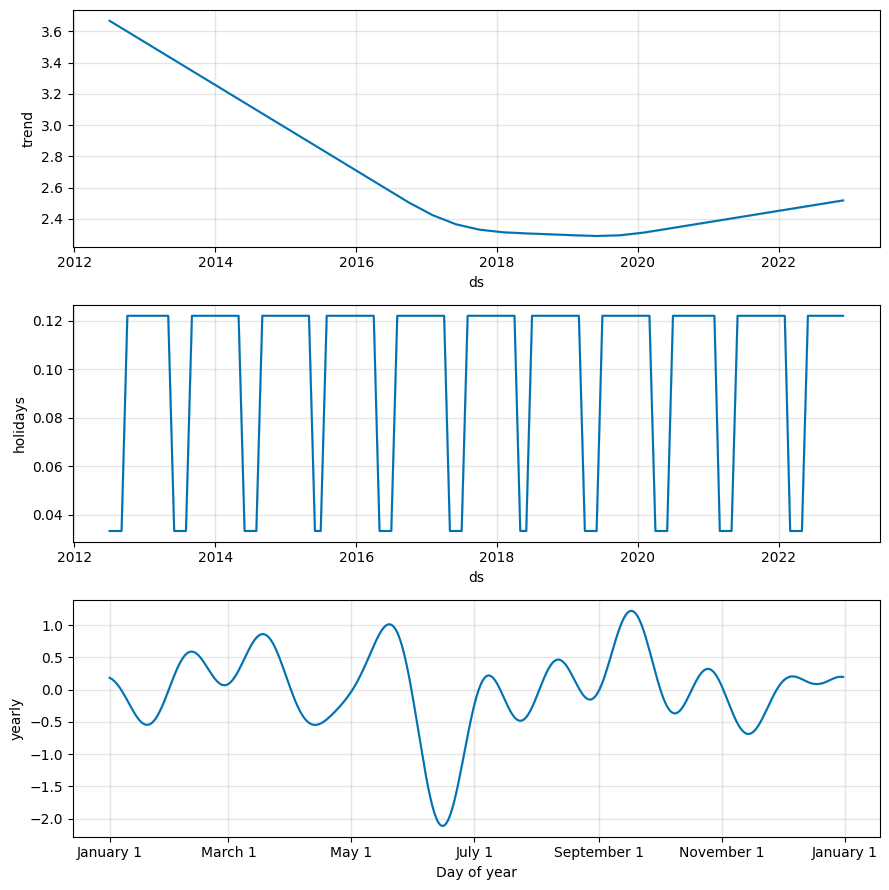

In [3230]:
model.plot_components(prophet_pred);


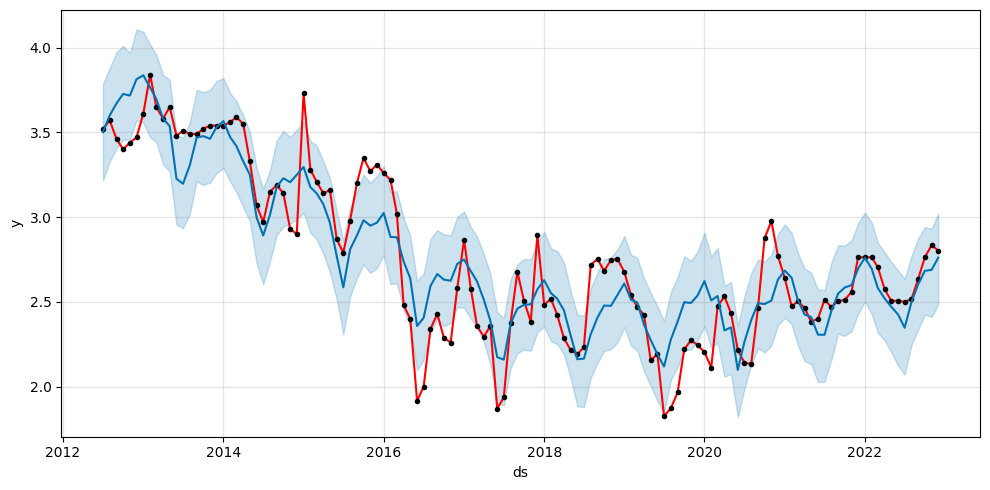

In [3231]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(newdata['ds'],newdata['y'],color='r')
fig=model.plot(prophet_pred,ax=ax)
plt.show()

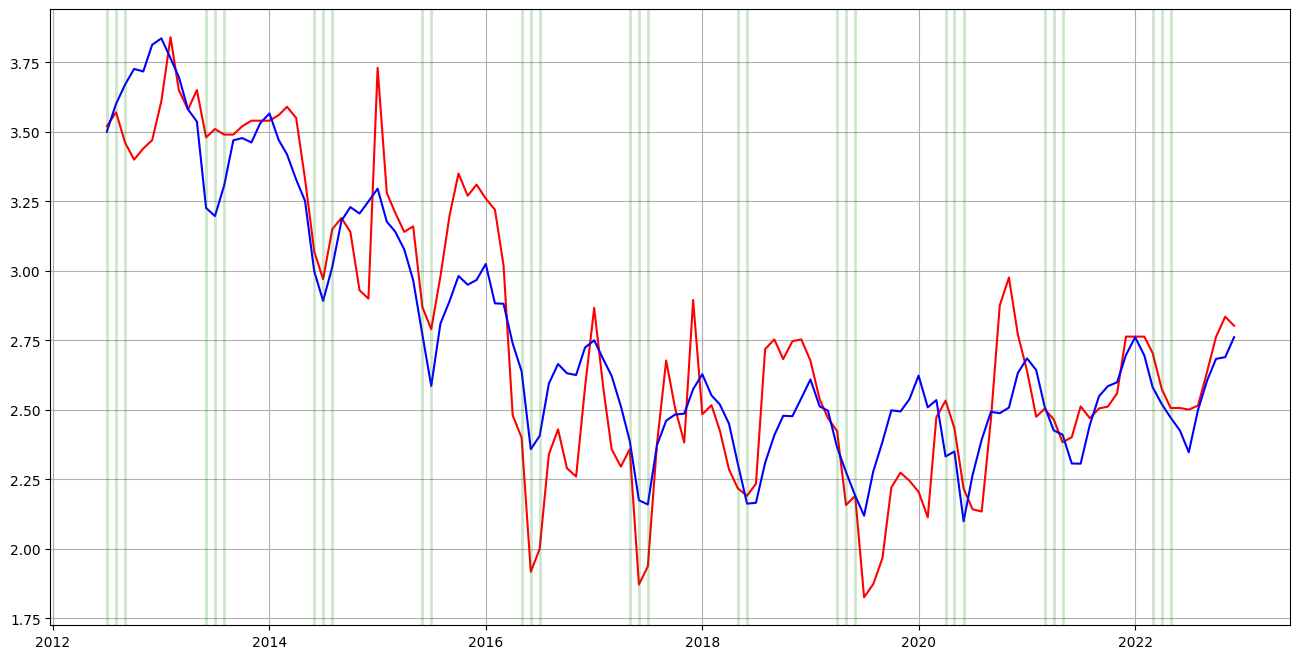

In [3232]:
# plot the prediction with the actual price 
fig,ax=plt.subplots(figsize=(16,8))
ax.plot(newdata['ds'],newdata['y'],color='r')
plt.plot(prophet_pred['ds'],prophet_pred['yhat'],color='b')
for x in df[df['is_ramdan']==1].index:
    ax.axvline(x=x,color='g',alpha=0.2,linewidth=2)
plt.grid()
plt.show()

In [3233]:
# to test the results 
mse = mean_squared_error(newdata['y'], prophet_pred['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(newdata['y'], prophet_pred['yhat'])
r2 = r2_score(newdata['y'], prophet_pred['yhat'])
mape=mean_absolute_percentage_error(newdata['y'], prophet_pred['yhat'])
# print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean absolute percentage error: {mape:.2f}")
print(f"R-squared (R²): {r2:.2f}")




Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.21
Mean Absolute Error (MAE): 0.16
Mean absolute percentage error: 0.06
R-squared (R²): 0.83


In [3234]:
future=model.make_future_dataframe(periods=13,freq='M',include_history=False)
forecast=model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,ramdan,ramdan_lower,ramdan_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-12-31,2.523887,2.439018,2.975006,2.523887,2.523887,0.198764,0.198764,0.198764,0.0,...,0.0,0.0,0.0,0.198764,0.198764,0.198764,0.0,0.0,0.0,2.722651
1,2023-01-31,2.530064,2.271944,2.821005,2.529499,2.530687,0.013066,0.013066,0.013066,0.0,...,0.0,0.0,0.0,0.013066,0.013066,0.013066,0.0,0.0,0.0,2.543129
2,2023-02-28,2.535642,2.340504,2.869807,2.534135,2.537220,0.070375,0.070375,0.070375,0.0,...,0.0,0.0,0.0,0.070375,0.070375,0.070375,0.0,0.0,0.0,2.606017
3,2023-03-31,2.541819,2.408526,2.940849,2.538932,2.544859,0.127193,0.127193,0.127193,0.0,...,0.0,0.0,0.0,0.127193,0.127193,0.127193,0.0,0.0,0.0,2.669012
4,2023-04-30,2.547796,2.193087,2.724728,2.543438,2.552024,-0.093277,-0.093277,-0.093277,0.0,...,0.0,0.0,0.0,-0.093277,-0.093277,-0.093277,0.0,0.0,0.0,2.454519
5,2023-05-31,2.553972,2.328029,2.856440,2.547891,2.560231,0.045400,0.045400,0.045400,0.0,...,0.0,0.0,0.0,0.045400,0.045400,0.045400,0.0,0.0,0.0,2.599372
6,2023-06-30,2.559949,1.870918,2.406089,2.551885,2.568225,-0.431564,-0.431564,-0.431564,0.0,...,0.0,0.0,0.0,-0.431564,-0.431564,-0.431564,0.0,0.0,0.0,2.128385
7,2023-07-31,2.566126,2.093046,2.621927,2.555732,2.576393,-0.210900,-0.210900,-0.210900,0.0,...,0.0,0.0,0.0,-0.210900,-0.210900,-0.210900,0.0,0.0,0.0,2.355226
8,2023-08-31,2.572302,2.193373,2.765387,2.560135,2.584767,-0.082595,-0.082595,-0.082595,0.0,...,0.0,0.0,0.0,-0.082595,-0.082595,-0.082595,0.0,0.0,0.0,2.489707
9,2023-09-30,2.578279,2.491984,3.020546,2.564053,2.593062,0.189113,0.189113,0.189113,0.0,...,0.0,0.0,0.0,0.189113,0.189113,0.189113,0.0,0.0,0.0,2.767392


In [3235]:
newdata['holiday']=data_2['holiday']
future['holiday']=('not ramdan',)*3+('ramdan',)*2+('not ramdan',)*8
future['y']=forecast['yhat']

In [3236]:
alldata=pd.concat([newdata,future], axis=0)
alldata.tail(17)

,ds,y,holiday
122,2022-09-01,2.637500,not ramdan
123,2022-10-01,2.762500,not ramdan
124,2022-11-01,2.835000,not ramdan
125,2022-12-01,2.802500,not ramdan
0,2022-12-31,2.722651,not ramdan
1,2023-01-31,2.543129,not ramdan
2,2023-02-28,2.606017,not ramdan
3,2023-03-31,2.669012,ramdan
4,2023-04-30,2.454519,ramdan
5,2023-05-31,2.599372,not ramdan


In [3237]:
future

,ds,holiday,y
0,2022-12-31,not ramdan,2.722651
1,2023-01-31,not ramdan,2.543129
2,2023-02-28,not ramdan,2.606017
3,2023-03-31,ramdan,2.669012
4,2023-04-30,ramdan,2.454519
5,2023-05-31,not ramdan,2.599372
6,2023-06-30,not ramdan,2.128385
7,2023-07-31,not ramdan,2.355226
8,2023-08-31,not ramdan,2.489707
9,2023-09-30,not ramdan,2.767392


In [3238]:
alldata['ds']

0    2012-07-01
1    2012-08-01
2    2012-09-01
3    2012-10-01
4    2012-11-01
        ...    
8    2023-08-31
9    2023-09-30
10   2023-10-31
11   2023-11-30
12   2023-12-31
Name: ds, Length: 139, dtype: datetime64[ns]

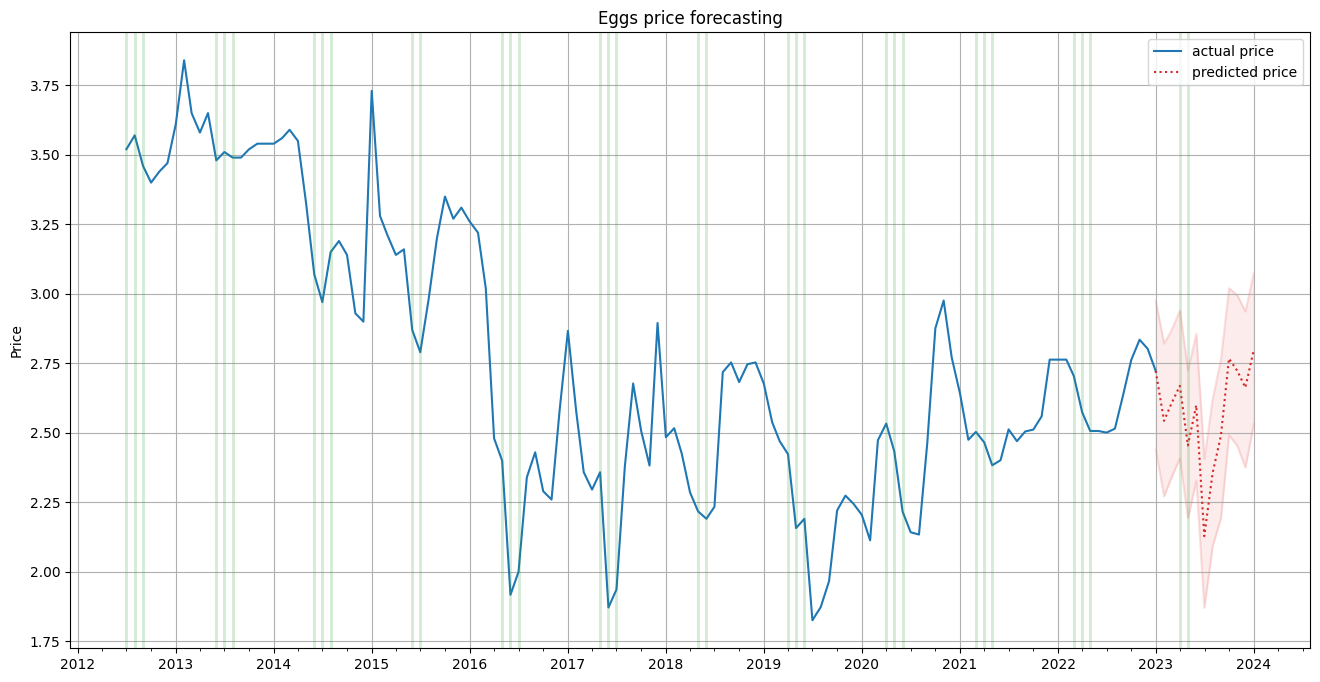

In [3243]:
# plot the prediction with the actual price 

fig,ax=plt.subplots(figsize=(16,8))
ax.plot(alldata['ds'][:-12], alldata['y'][:-12], color='tab:blue',label='actual price')
ax.plot(alldata['ds'][-13:], alldata['y'][-13:], color='tab:red',linestyle='dotted',label='predicted price')

plt.fill_between(alldata['ds'][-13:], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.15,color='lightcoral')

ax.plot(alldata['ds'][-13:], forecast['yhat_lower'], color='lightcoral', alpha=0.2)
ax.plot(alldata['ds'][-13:], forecast['yhat_upper'], color='lightcoral', alpha=0.2)

for x in alldata[alldata['holiday']=='ramdan']['ds']:
    ax.axvline(x=x,color='tab:green',alpha=0.2,linewidth=2)
ax.set_ylabel('Price')

# ax.set_xticks()
# ax.set_xticklabels(alldata['ds'])
ax.legend(loc='upper right')

date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1, 4, 7, 10]))
plt.title(f'{chosen_commidity} price forecasting')
plt.grid()
plt.savefig(f'{chosen_commidity} price prediction')
plt.show()

In [3240]:
alldata.tail(24)

,ds,y,holiday
115,2022-02-01,2.763333,not ramdan
116,2022-03-01,2.704167,ramdan
117,2022-04-01,2.574167,ramdan
118,2022-05-01,2.506667,ramdan
119,2022-06-01,2.506667,not ramdan
120,2022-07-01,2.500833,not ramdan
121,2022-08-01,2.515000,not ramdan
122,2022-09-01,2.637500,not ramdan
123,2022-10-01,2.762500,not ramdan
124,2022-11-01,2.835000,not ramdan
